# Training a QRNN

This notebooke train a simple QRNN on a small subset of the training data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Defining the QRNN

To create a `QRNN` we import the QRNN class from the `typhon` module. We define the quantiles that we want to predict and then instantiate the `QRNN` class providing as input arguments the number of input feature of the Gprof dataset (13 channels + 3 ancillary variables = 16), the quantiles and a tuple describing the architecture
of the network. `(6, 256, "relu")` means that we want a fully-connected network with 6 hidden layers, each with 128 neurons and ReLU activation functions.

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])
qrnn = QRNN(16, quantiles, (6, 256, "relu"))

Using TensorFlow backend.


## Loading the training data

Next, we load the training data. The `GprofData` class in the `regn.data` module implements the pytorch dataset interface so which makes it easier to use our data with `pytorch` models. We create an object of the class providing the file containing the training data and specifying the desired batch size for training. Then we split the data into training and validation part. The validation part is not presented to the model but is simply used to monitor the model error.

In [4]:
from torch.utils.data import DataLoader, random_split
from regn.data import GprofData
data = GprofData("../../data/training_data_small.nc",
                 batch_size = 256)
n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])

## Training the model

In [5]:
qrnn.train(training_data, validation_data, n_epochs = 10, lr = 1e-3, momentum = 0.99, gpu = True)
qrnn.train(training_data, validation_data, n_epochs = 10, lr = 5e-4, momentum = 0.99, gpu = True)
qrnn.train(training_data, validation_data, n_epochs = 10, lr = 1e-4, momentum = 0.0, gpu = True)

Finally, we save the model to reuse it later.

In [6]:
qrnn.save("../../models/qrnn_6_256_all_surfaces.nc")

## Evaluating the QRNN

To ensure the training was successful, let's plot the calibration of the predicted confidence intervals.

Text(0, 0.5, 'Observed frequency')

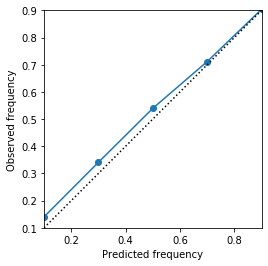

In [10]:
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o")
ax.plot(x, x, ls = ":", c = "k")
ax.set_xlim([0.1, 0.9])
ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")